
# Data preprocessing

In [2]:
import numpy as np
import scipy.sparse as sps
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

from Recommenders.Hybrids.Hybrid_SlimElastic_Rp3 import Hybrid_SlimElastic_Rp3

from Recommenders.Incremental_Training_Early_Stopping import Incremental_Training_Early_Stopping
from Recommenders.KNN.ItemKNNCBFWeightedSimilarityRecommender import ItemKNNCBFWeightedSimilarityRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.MatrixFactorization.IALSRecommender_implicit import IALSRecommender_implicit
from Recommenders.Recommender_import_list import *
from Recommenders.Recommender_utils import check_matrix
from reader import load_urm, load_icm, load_target
from run_all_algorithms import _get_instance
from sklearn import feature_extraction


In [3]:
res_dir = 'result_experiments/csv'
output_root_path = "../result_experiments/"


In [4]:
URM_all, user_id_unique, item_id_unique = load_urm()

ICM_channel = load_icm("data_ICM_channel.csv", weight=1)
ICM_event = load_icm("data_ICM_event.csv", weight=1)
ICM_genre = load_icm("data_ICM_genre.csv", weight=1)
ICM_subgenre = load_icm("data_ICM_subgenre.csv", weight=1)

ICM_all = sps.hstack([ICM_genre, ICM_subgenre, ICM_channel, ICM_event]).tocsr()
ICMs = [ICM_genre, ICM_subgenre, ICM_channel, ICM_event, ICM_all]

In [5]:

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.90)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


#print(n_users)

EvaluatorHoldout: Ignoring 13610 ( 0.3%) Users that have less than 1 test interactions


In [6]:
n_users = 13650
n_item = 18059

In [7]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
print("profile", profile_length, profile_length.shape)

block_size = int(len(profile_length)*0.5)
print("block_size",block_size)

sorted_users = np.argsort(profile_length)
print("sorted users", sorted_users)

profile [147 540 130 ... 240 166 299] (13650,)
block_size 6825
sorted users [11326  9021 11781 ...  1141  8526   317]


array([3909, 5214, 2731, 1154,  407,  148,   48,   31,    6,    2])

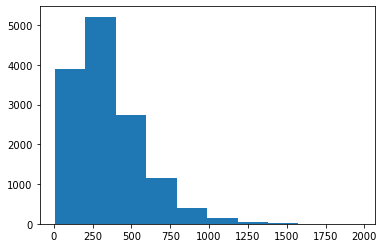

In [51]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(profile_length)
plt.hist(bins[:-1], bins, weights=counts)
bins
counts

array([   7.,  203.,  399.,  595.,  791.,  987., 1183., 1379., 1575.,
       1771.])

In [52]:
for group_id in range(0, 2):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 6825, average p.len 178.63, median 187.0, min 7, max 306
Group 1, #users in group 6825, average p.len 518.38, median 461.0, min 306, max 1967


In [56]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
                                   "PureSVDRecommender": PureSVDRecommender,
                                   }

#content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
#                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
#                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():

            recommender_object = recommender_class(URM_train)

            if isinstance(recommender_object, ItemKNNCFRecommender):
                fit_params = {"topK": 200, "shrink": 200, "feature_weighting": "TF-IDF"}
            elif isinstance(recommender_object, IALSRecommender):
                fit_params = {'num_factors': 55, 'epochs': 50, 'confidence_scaling': 'log',
                              'alpha': 0.06164752624981533, 'epsilon': 0.21164021855039056, 'reg': 0.002507116338282967}
            elif isinstance(recommender_object, RP3betaRecommender):
                fit_params = {'topK': 40, 'alpha': 0.4208737801266599, 'beta': 0.5251543657397256,
                              'normalize_similarity': True}
            elif isinstance(recommender_object, PureSVDRecommender):
                fit_params = {'num_factors' :29}    
            else:
                fit_params = {}     

            if isinstance(recommender_object, SLIMElasticNetRecommender):
              recommender_object.load_model(output_root_path, file_name="slimelastic_urmall.zip")
            else:
              recommender_object.fit(**fit_params)

            recommender_object_dict[label] = recommender_object

# for label, recommender_class in content_recommender_class.items():
#    recommender_object = recommender_class(URM_train, ICM_genres)
#    recommender_object.fit()
#    recommender_object_dict[label] = recommender_object


Similarity column 13650 (100.0%), 345.08 column/sec. Elapsed time 39.56 sec
Similarity column 18059 (100.0%), 931.73 column/sec. Elapsed time 19.38 sec
SLIMElasticNetRecommender: Loading model from file '../result_experiments/slimelastic_urmall.zip'
SLIMElasticNetRecommender: Loading complete
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.90 sec


In [54]:
%ls

content-based-filtering.ipynb  non-personalized.ipynb
groupusers.ipynb               preprocessing.ipynb


In [57]:
cutoff = 10

for group_id in range(0, 2):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 6825, average p.len 178.63, median 187.0, min 7, max 306
EvaluatorHoldout: Ignoring 13614 ( 0.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 6825 Users
EvaluatorHoldout: Processed 6789 (100.0%) in 8.79 sec. Users per second: 772
EvaluatorHoldout: Processed 6789 (100.0%) in 6.67 sec. Users per second: 1017
EvaluatorHoldout: Processed 6789 (100.0%) in 17.59 sec. Users per second: 386
EvaluatorHoldout: Processed 6789 (100.0%) in 6.27 sec. Users per second: 1083
EvaluatorHoldout: Processed 6789 (100.0%) in 7.12 sec. Users per second: 953
EvaluatorHoldout: Processed 6789 (100.0%) in 12.57 sec. Users per second: 540
EvaluatorHoldout: Processed 6789 (100.0%) in 8.96 sec. Users per second: 758
Group 1, #users in group 6825, average p.len 518.38, median 461.0, min 306, max 1967
EvaluatorHoldout: Ignoring 13614 ( 0.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 6825 Users
EvaluatorHoldout: Processed 6825 (100.0%

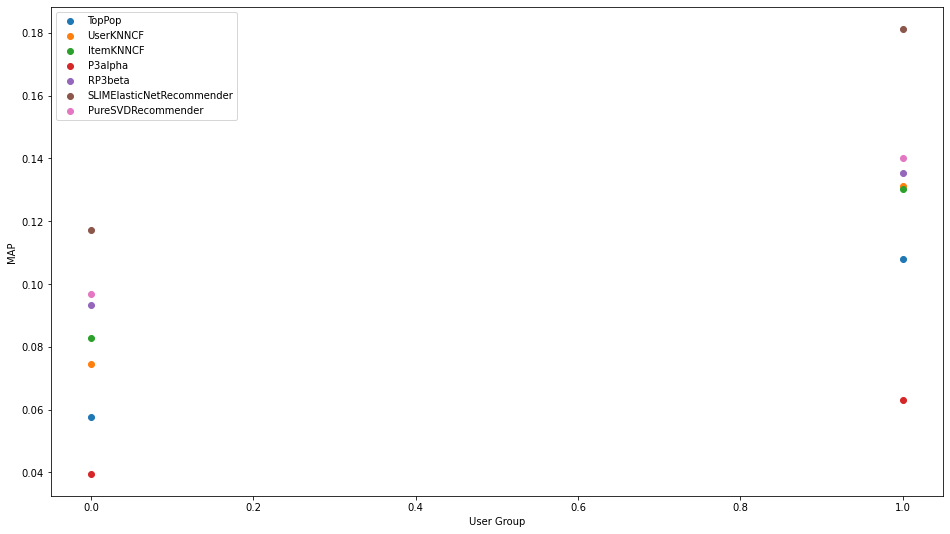

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()